In [1]:
import os
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from scipy import stats
from tqdm import tqdm
from ezephys import pltools

from lib.data import conditions as cond
from lib.data import tables as tab
from lib.features import decomposition as de
from lib.features import correlation as corr

In [2]:
np.random.seed(42)
plt.rc('svg', fonttype='none')

# Load data

In [3]:
engine = tab.sa.create_engine(os.environ['SQLALCHEMY_ENGINE_URL'])
Session = tab.sa.orm.sessionmaker(bind=engine)
session = Session()

Get the IDs of all cells that were added to the dataset on the first day.

In [4]:
day_one_cells = (
    session.query(tab.Cell)
    .join(tab.Cell.traces, tab.Trial)
    .filter(tab.Trial.day == 1)
    .subquery()
)

Get the average traces for non-catch trials of `day_one_cells` on days 1 and 7.

In [5]:
(
    session.query(tab.TrialAverageTrace, tab.Mouse)
        .join(day_one_cells, tab.TrialAverageTrace.cell_id==day_one_cells.c.id)
        .filter(tab.Mouse)
)

AttributeError: 'Query' object has no attribute 'select'

In [ ]:
session.query(tab.TrialAverateTrace, tab.Mouse)

In [5]:
average_traces = []
days = []
cell_types = []
cell_ids = []
mouse_ids = []

for res in tqdm(
    session.query(tab.TrialAverageTrace, tab.Mouse)
        .join(day_one_cells, tab.TrialAverageTrace.cell_id==day_one_cells.c.id)
        .join(tab.Mouse, day_one_cells.c.mouse_id==tab.Mouse.id)
        .filter(
            tab.TrialAverageTrace.day.in_([1, 7]), 
            tab.TrialAverageTrace.trial_kind == 'non_catch',
            tab.Mouse.cell_type != cond.CellType.som,  # Excluded b/c few neurons
            tab.Mouse.id != 'CL199',  # Excluded b/c fluorescence drift
        )
        .all()
):
    if not all(np.isnan(res[0].trace)):
        average_traces.append(res[0].trace)
        days.append(res[0].day)
        cell_ids.append(res[0].cell_id)
        cell_types.append(res[1].cell_type)
        mouse_ids.append(res[1].id)

100%|██████████| 3864/3864 [00:00<00:00, 182459.59it/s]


In [6]:
average_traces = np.array([tr[:390] for tr in average_traces])
days = np.array(days)
cell_types = np.array(cell_types)
cell_ids = np.array(cell_ids)

In [7]:
average_traces.shape

(3851, 390)

In [8]:
days

array([1, 7, 1, ..., 7, 1, 7])

In [9]:
cell_types

array([CellType.vip, CellType.vip, CellType.vip, ..., CellType.pv,
       CellType.pv, CellType.pv], dtype=object)

In [10]:
np.sum((days == 1) & (cell_types == cond.CellType.vip))

407

The data I imported has 407 VIP cells on day 1. If I did everything right, that should match your analysis.

# Helper function for saving figures

In [11]:
def savefig(fig_basename, **kwargs):
    for extension in ['png', 'svg']:
        print(f'Saving {extension}')
        plt.savefig('.'.join([fig_basename, extension]), **kwargs)

**Trial components**

Durations are in seconds.

In [12]:
trial_structure = de.TrialBasisFunctions(
    390, tone_duration=1.0, delay_duration=1.5, reward_duration=2.5
)

Trial structure is represented in terms of a set of rectangular functions. Here's one of them.

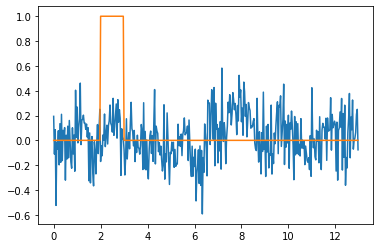

In [13]:
plt.plot(trial_structure.time, average_traces[10, :])
plt.plot(trial_structure.time, trial_structure.tone)

In [22]:
spearman_corr = {
    'tone': corr.vectorized_spearman_corr(average_traces, trial_structure.tone),
    'tone + delay': corr.vectorized_spearman_corr(average_traces, trial_structure.tone + trial_structure.delay),
    'reward': corr.vectorized_spearman_corr(average_traces, trial_structure.reward),
}

mean_fluorescence = {
    lab: average_traces[:, trial_component].sum(axis=1) / trial_component.sum()
    for lab, trial_component in {
        'tone fluo': trial_structure.tone, 
        'tone + delay fluo': trial_structure.tone + trial_structure.delay,
        'reward fluo': trial_structure.reward
    }.items()
}

In [23]:
mean_fluo_df = pd.DataFrame(
    {
        'day': days,
        'cell_type': cell_types,
        'cell_id': cell_ids,
        'mouse_id': mouse_ids,
        **mean_fluorescence,
        **spearman_corr
    }
)
mean_fluo_df

,day,cell_type,cell_id,mouse_id,tone fluo,tone + delay fluo,reward fluo,tone,tone + delay,reward
0,1,vip,3121,CL136,0.006833,-0.006349,-0.015298,-0.042650,-0.089601,-0.110405
1,7,vip,3121,CL136,0.056056,0.292485,0.064681,-0.205642,-0.022913,-0.320235
2,1,vip,3122,CL136,0.078297,0.026572,-0.122830,0.110171,0.048225,-0.311567
3,7,vip,3122,CL136,-0.027618,-0.061786,0.218031,-0.240343,-0.429629,-0.054292
4,1,vip,3123,CL136,-0.002098,0.013350,0.032032,-0.062735,-0.045220,-0.022335
...,...,...,...,...,...,...,...,...,...,...
3846,7,pv,2644,CL198,-0.107898,-0.029546,0.055185,-0.157180,-0.062845,0.159005
3847,1,pv,2645,CL198,-0.010278,0.062069,0.016830,-0.063077,0.110058,-0.012685
3848,7,pv,2645,CL198,-0.155872,-0.061751,0.062192,-0.254787,-0.206854,0.091508
3849,1,pv,2646,CL198,-0.015687,0.043476,0.038258,-0.070769,0.044699,0.033546


In [24]:
mean_fluo_df.describe()

,day,cell_id,tone fluo,tone + delay fluo,reward fluo,tone,tone + delay,reward
count,3851.000000,3851.000000,3851.000000,3851.000000,3851.000000,3851.000000,3851.000000,3851.000000
mean,3.999221,1750.525837,-0.018973,0.016781,0.052694,-0.039512,-0.013280,-0.011403
std,3.000389,1065.270517,0.163003,0.204041,0.321128,0.191138,0.225682,0.246005
min,1.000000,1.000000,-0.871482,-1.354365,-1.732902,-0.460685,-0.672803,-0.676155
25%,1.000000,959.000000,-0.108639,-0.060397,-0.074515,-0.169189,-0.148719,-0.161663
50%,1.000000,1722.000000,-0.030930,-0.000665,0.009453,-0.062564,-0.019157,-0.011876
75%,7.000000,2784.500000,0.052006,0.062426,0.109973,0.070769,0.105204,0.128984
max,7.000000,3526.000000,1.546521,6.798667,6.605481,0.461369,0.663499,0.682511


In [25]:
mean_fluo_df.to_csv('../../interneuron-reward-data/processed/mean_fluo_df.csv', index=False)

In [26]:
def mark_trial_structure():
    plt.axvspan(
        min(trial_structure.time[trial_structure.tone]) - trial_structure.baseline_duration,
        max(trial_structure.time[trial_structure.tone]) - trial_structure.baseline_duration,
        color=(0.8, 0.8, 0.8),
        label='Tone'
    )
    plt.axvline(
        min(trial_structure.time[trial_structure.reward]) - trial_structure.baseline_duration,
        color=(0.8, 0.8, 0.8),
        ls='--',
        label='Reward delivery',
    )

In [27]:
def to_unit_interval(x):
    return (x + 1) * 0.5

Cell types to show for tone + delay:      cell_type  tone + delay
1988       pyr     -0.569881
1850       pyr     -0.644891
2026       pyr     -0.667255
1308       pyr     -0.246208
475        vip     -0.251525
463        vip     -0.045797
2288       pyr      0.306828
2512       pyr      0.242798
2508       pyr      0.373400
2500       pyr      0.221243
Cell types to show for reward:      cell_type    reward
2296       pyr -0.669047
2534       pyr -0.577972
2442       pyr -0.631368
2256       pyr -0.634027
846         pv -0.122483
1820       pyr -0.236442
1850       pyr  0.589645
3282       pyr  0.669913
1988       pyr  0.192754
2522       pyr  0.647260
Saving png


<ipython-input-28-aa2fc41814c0>:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving svg


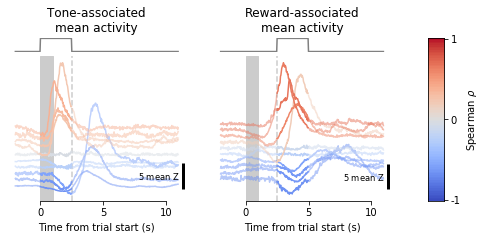

In [28]:
plt.figure(figsize=(8, 3))

spec = gs.GridSpec(
    2, 3, width_ratios=[1, 1, 0.2], height_ratios=[0.1, 1], hspace=0.05
)

for i, (trial_component, label, mask) in enumerate(
    zip(
        ['tone + delay', 'reward'], 
        ['Tone-associated\nmean activity', 'Reward-associated\nmean activity'],
        [trial_structure.tone + trial_structure.delay, trial_structure.reward]
    )
):

    # Find the inds of cells with various values of mean fluorescence
    all_cell_fluo_means = mean_fluo_df.loc[
        mean_fluo_df['day'] == cond.Day(7), 
        trial_component + ' fluo'
    ].to_numpy()
    inds_sorted_by_mean = np.argsort(all_cell_fluo_means)
    cells_to_show = np.concatenate([
        inds_sorted_by_mean[:4], 
        inds_sorted_by_mean[int(len(inds_sorted_by_mean) // 2)-1:int(len(inds_sorted_by_mean) // 2)+1],
        inds_sorted_by_mean[-4:]
    ])
    print(f'Cell types to show for {trial_component}: {mean_fluo_df.loc[mean_fluo_df["day"] == cond.Day(7), ["cell_type", trial_component]].iloc[cells_to_show, :]}')

    traces_ = average_traces[days == cond.Day(7), :][cells_to_show, :].T
    means_ = mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), trial_component].iloc[cells_to_show]


    plt.subplot(spec[0, i])
    plt.title(label)
    plt.plot(
        trial_structure.time - trial_structure.baseline_duration,
        mask,
        color='gray',
    )
    plt.gca().axis('off')
    
    plt.subplot(spec[1, i])
    mark_trial_structure()
    
    for j, k in enumerate(np.argsort(means_)):
        component = traces_[:, k].copy()
        component[~mask] = np.nan
        
        plt.plot(
            trial_structure.time - trial_structure.baseline_duration,
            component + j*1.2,
            color=plt.cm.coolwarm(to_unit_interval(means_.iloc[k]))
        )
        
        not_component = traces_[:, k].copy()
        not_component[mask] = np.nan
        
        plt.plot(
            trial_structure.time - trial_structure.baseline_duration,
            not_component + j*1.2,
            color=plt.cm.coolwarm(to_unit_interval(means_.iloc[k])),
            alpha=0.5
        )
    
    pltools.add_scalebar(y_units=' mean Z', remove_frame=False, omit_x=True)
    pltools.hide_border('trl', trim=True)
    
    plt.xlabel('Time from trial start (s)')
    
ax = plt.subplot(spec[:, -1])
plt.imshow(np.linspace(1, -1, 101)[:, np.newaxis], cmap='coolwarm', aspect=0.1)
plt.yticks([0, 50, 100], [1, 0, -1])
plt.gca().yaxis.set_ticks_position('right')
plt.gca().yaxis.set_label_position('right')
plt.ylabel('Spearman $\\rho$')
plt.xticks([])

plt.tight_layout()

savefig('../img/graphics/sample_responsive_cells', dpi=600, bbox_inches='tight')

del cells_to_show, traces_, means_

Cell types to show for tone + delay:      cell_type  tone + delay
475        vip     -0.251525
463        vip     -0.045797
2288       pyr      0.306828
2512       pyr      0.242798
2508       pyr      0.373400
2500       pyr      0.221243
Cell types to show for reward:      cell_type    reward
846         pv -0.122483
1820       pyr -0.236442
1850       pyr  0.589645
3282       pyr  0.669913
1988       pyr  0.192754
2522       pyr  0.647260
Saving png


<ipython-input-35-c76ffcb764c3>:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving svg


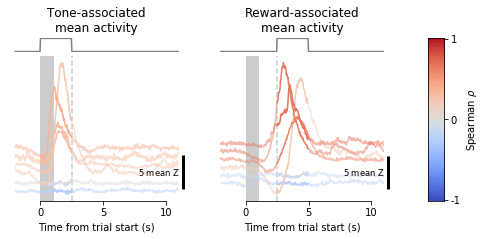

In [35]:
plt.figure(figsize=(8, 3))

spec = gs.GridSpec(
    2, 3, width_ratios=[1, 1, 0.2], height_ratios=[0.1, 1], hspace=0.05
)

for i, (trial_component, label, mask) in enumerate(
    zip(
        ['tone + delay', 'reward'], 
        ['Tone-associated\nmean activity', 'Reward-associated\nmean activity'],
        [trial_structure.tone + trial_structure.delay, trial_structure.reward]
    )
):

    # Find the inds of cells with various values of mean fluorescence
    all_cell_fluo_means = mean_fluo_df.loc[
        mean_fluo_df['day'] == cond.Day(7), 
        trial_component + ' fluo'
    ].to_numpy()
    inds_sorted_by_mean = np.argsort(all_cell_fluo_means)
    cells_to_show = np.concatenate([
        inds_sorted_by_mean[int(len(inds_sorted_by_mean) // 2)-1:int(len(inds_sorted_by_mean) // 2)+1],
        inds_sorted_by_mean[-4:]
    ])
    print(f'Cell types to show for {trial_component}: {mean_fluo_df.loc[mean_fluo_df["day"] == cond.Day(7), ["cell_type", trial_component]].iloc[cells_to_show, :]}')

    traces_ = average_traces[days == cond.Day(7), :][cells_to_show, :].T
    means_ = mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), trial_component].iloc[cells_to_show]


    plt.subplot(spec[0, i])
    plt.title(label)
    plt.plot(
        trial_structure.time - trial_structure.baseline_duration,
        mask,
        color='gray',
    )
    plt.gca().axis('off')
    
    plt.subplot(spec[1, i])
    mark_trial_structure()
    
    for j, k in enumerate(np.argsort(means_)):
        component = traces_[:, k].copy()
        component[~mask] = np.nan
        
        plt.plot(
            trial_structure.time - trial_structure.baseline_duration,
            component + j*1.2,
            color=plt.cm.coolwarm(to_unit_interval(means_.iloc[k]))
        )
        
        not_component = traces_[:, k].copy()
        not_component[mask] = np.nan
        
        plt.plot(
            trial_structure.time - trial_structure.baseline_duration,
            not_component + j*1.2,
            color=plt.cm.coolwarm(to_unit_interval(means_.iloc[k])),
            alpha=0.5
        )
    
    pltools.add_scalebar(y_units=' mean Z', remove_frame=False, omit_x=True)
    pltools.hide_border('trl', trim=True)
    
    plt.xlabel('Time from trial start (s)')
    
ax = plt.subplot(spec[:, -1])
plt.imshow(np.linspace(1, -1, 101)[:, np.newaxis], cmap='coolwarm', aspect=0.1)
plt.yticks([0, 50, 100], [1, 0, -1])
plt.gca().yaxis.set_ticks_position('right')
plt.gca().yaxis.set_label_position('right')
plt.ylabel('Spearman $\\rho$')
plt.xticks([])

plt.tight_layout()

savefig('../img/graphics/sample_pos_responsive_cells', dpi=600, bbox_inches='tight')

del cells_to_show, traces_, means_

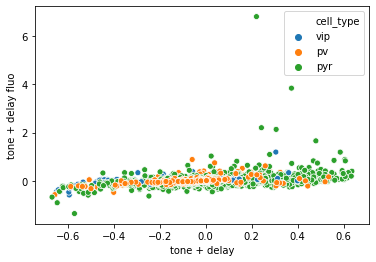

In [30]:
sns.scatterplot('tone + delay', 'tone + delay fluo', 'cell_type', data=mean_fluo_df.loc[mean_fluo_df['day'] == 7, :])

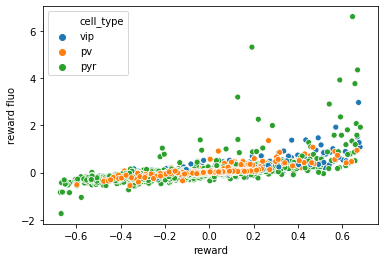

In [32]:
sns.scatterplot('reward', 'reward fluo', 'cell_type', data=mean_fluo_df.loc[mean_fluo_df['day'] == 7, :])

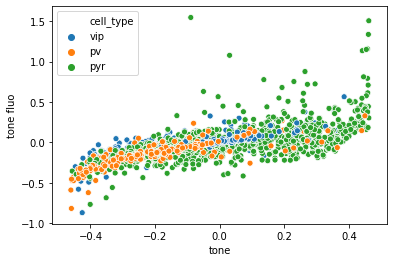

In [31]:
sns.scatterplot('tone', 'tone fluo', 'cell_type', data=mean_fluo_df.loc[mean_fluo_df['day'] == 7, :])

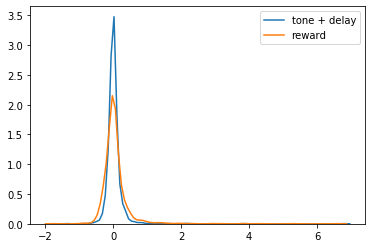

In [34]:
sns.kdeplot(mean_fluo_df.loc[(mean_fluo_df['day'] == 7), 'tone + delay fluo'], label='tone + delay')
sns.kdeplot(mean_fluo_df.loc[(mean_fluo_df['day'] == 7), 'reward fluo'], label='reward')
plt.legend()

In [21]:
FRAME_RATE = 30.0
BASELINE_DURATION = 2.
time_vec = np.arange(390) / FRAME_RATE - BASELINE_DURATION

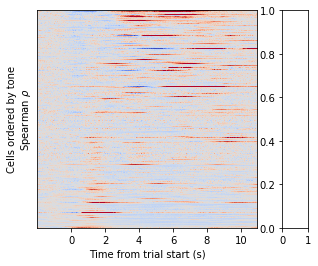

In [23]:
celltype_number = {
    cond.CellType.pyr: 0,
    cond.CellType.vip: 1,
    cond.CellType.pv: 2
}

Saving png
Saving svg


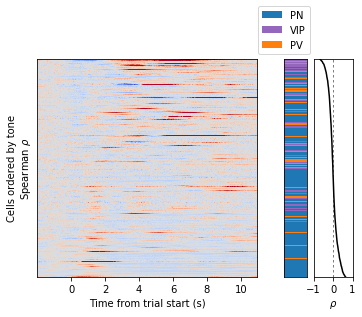

In [24]:
fluo_spec = gs.GridSpec(1, 3, width_ratios=[1, 0.1, 0.15], wspace=0.05)

plt.subplot(fluo_spec[:, 0])
plt.imshow(
    average_traces[
        days == cond.Day(7), 
        :
    ][
        np.argsort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'tone + delay']),
        :
    ],
    cmap='coolwarm',
    vmin=-2,
    vmax=2,
    aspect=0.2
)
plt.xticks((np.arange(0, 11, 2) + BASELINE_DURATION) * FRAME_RATE, np.arange(0, 11, 2))
plt.yticks([])
plt.ylabel('Cells ordered by tone\nSpearman $\\rho$')
plt.xlabel('Time from trial start (s)')

ax = plt.subplot(fluo_spec[:, 1])
ct_barcode = ax.imshow(
    np.array([celltype_number[ct] 
              for ct in 
              cell_types[days==7][np.argsort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'tone + delay'])]]
            )[:, np.newaxis], 
    aspect=0.005,
    cmap=ListedColormap([sns.color_palette()[i] for i in [0, 4, 1]])
)
ax.set_yticks([])
ax.set_xticks([])
ax.legend(handles=[
    Patch(facecolor=sns.color_palette()[0], label='PN'), 
    Patch(facecolor=sns.color_palette()[4], label='VIP'), 
    Patch(facecolor=sns.color_palette()[1], label='PV'), 
], loc='lower center', bbox_to_anchor=(0, 1))

plt.subplot(fluo_spec[:, 2])
plt.axvline(0, color='k', ls='--', lw=0.5, dashes=(5, 5))
plt.plot(
    np.sort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'tone + delay']),
    np.linspace(1, 0, sum(mean_fluo_df['day'] == cond.Day(7))),
    'k-'
)
plt.ylim(0, 1)
plt.xlim(-1, 1)
plt.yticks([])
plt.xlabel('$\\rho$')

savefig('../img/graphics/fluo_ordered_by_tone', dpi=600, bbox_inches='tight')
plt.show()

In [25]:
stats.ks_2samp(
    mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(1), 'tone + delay'].to_numpy().flatten(),
    mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'tone + delay'].to_numpy().flatten()
)

Ks_2sampResult(statistic=0.04853663470485901, pvalue=0.020542850706364413)

Saving png
Saving svg


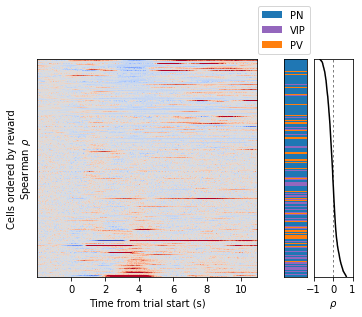

In [26]:
plt.subplot(fluo_spec[:, 0])
plt.imshow(
    average_traces[
        days == cond.Day(7), 
        :
    ][
        np.argsort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'reward']),
        :
    ],
    cmap='coolwarm',
    vmin=-2,
    vmax=2,
    aspect=0.2
)
plt.xticks((np.arange(0, 11, 2) + BASELINE_DURATION) * FRAME_RATE, np.arange(0, 11, 2))
plt.yticks([])
plt.ylabel('Cells ordered by reward\nSpearman $\\rho$')
plt.xlabel('Time from trial start (s)')

ax = plt.subplot(fluo_spec[:, 1])
ct_barcode = ax.imshow(
    np.array([celltype_number[ct] 
              for ct in 
              cell_types[days==7][np.argsort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'reward'])]]
            )[:, np.newaxis], 
    aspect=0.005,
    cmap=ListedColormap([sns.color_palette()[i] for i in [0, 4, 1]])
)
ax.set_yticks([])
ax.set_xticks([])
ax.legend(handles=[
    Patch(facecolor=sns.color_palette()[0], label='PN'), 
    Patch(facecolor=sns.color_palette()[4], label='VIP'), 
    Patch(facecolor=sns.color_palette()[1], label='PV'), 
], loc='lower center', bbox_to_anchor=(0, 1))

plt.subplot(fluo_spec[:, 2])
plt.axvline(0, color='k', ls='--', lw=0.5, dashes=(5, 5))
plt.plot(
    np.sort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'reward']),
    np.linspace(1, 0, sum(mean_fluo_df['day'] == cond.Day(7))),
    'k-'
)
plt.ylim(0, 1)
plt.xlim(-1, 1)
plt.yticks([])
plt.xlabel('$\\rho$')

savefig('../img/graphics/fluo_ordered_by_reward', dpi=600, bbox_inches='tight')

plt.show()

In [27]:
stats.ks_2samp(
    mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(1), 'reward'].to_numpy().flatten(),
    mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'reward'].to_numpy().flatten()
)

Ks_2sampResult(statistic=0.12013297190867284, pvalue=1.5393242236427795e-12)